# Exercise 06 - Data Fitting 1 (75 + 35 points)

In this exercise you will implement and employ linear and non-linear methods of data fitting to the task of camera response curve estimation. 
The camera response function represents the relation between scene irradiance to image brightness (pixel intensities). In a previous exercise we have already applied a non-parametric model to recover the camera response function for HDR imaging. In this exercise you will apply some of the data fitting methods introduced in the lecture to find model parameters $a$ that, given the irradiance, explain our observed brightness values best.

In [1]:
# Overall imports.
%matplotlib widget
import os

import matplotlib.pyplot as plt
import numpy as np
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
import scipy
from skimage.metrics import mean_squared_error
from tqdm.notebook import tqdm

## 1. Linear Regression on Camera Response Estimation (75 points)
The basic idea is to find model parameters $a$ for a function $f$ which describe the data as well as possible, ideally also generalizing over new, unseen data.
By running the next cell you can plot the available data which consists of a set of brightness values measured at a given irradiance on the sensor. There has been some noise added to simulate data that you would get from a real measurement process.

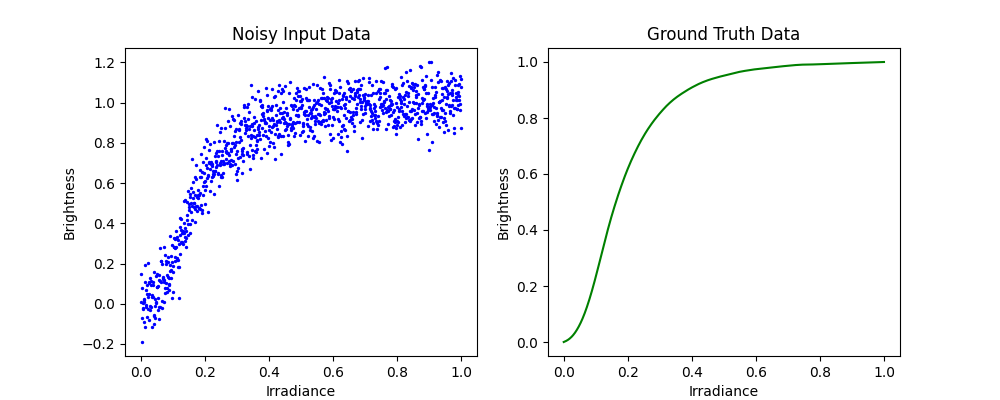

In [2]:
# Add additional imports.
import scipy.io
import scipy.optimize

# Load measured camera curve data.
cam_data = scipy.io.loadmat("camCurve.mat")
irradiance = cam_data["I"][0].astype(np.float32)
brightness = cam_data["B"][0].astype(np.float32)

# Add some noise.
rs = RandomState(MT19937(SeedSequence(121336779)))
brightness += rs.normal(0, 0.08, brightness.shape)

# Plot data.
fig = plt.figure(figsize=(10, 4))
ax = fig.subplots(1, 2)
ax[0].set_title("Noisy Input Data")
ax[0].scatter(irradiance, brightness, color="b", s=2)
ax[0].set_xlabel("Irradiance")
ax[0].set_ylabel("Brightness")
ax[1].set_title("Ground Truth Data")
ax[1].plot(irradiance, cam_data["B"][0].astype(np.float32), color="g")
ax[1].set_xlabel("Irradiance")
ax[1].set_ylabel("Brightness")
plt.show()

### 1.1 (30)
Your first task is to implement the gradient descent algorithm as the function `graddesc(a, b, tolerance, iterations, step_size)`. 

#### a) (10)
The error function to be optimized is $E = \|b-Ax\|_2^2$ with $A$ being your design matrix including the measurements, $b$ your observations and $x$ the parameters to be optimized. As a first step calculate the gradient analytically. 

_Hint_: You can put your derivation of the first order derivative of the error function in a Markdown cell using the math environment inside the notebook. It is also fine to include a scan, photo or pdf document. You might find the identities listed at [Wikipedia](https://en.wikipedia.org/wiki/Matrix_calculus) useful for the derivation. Keep in mind that $E(x)$ is a scalar function. If you find yourself stuck on this exercise, do the other exercises first.


### Derivation
$E = \|b-Ax\|_2^2$

Let b be a vector of length $n$, A a $n\times m$ matrix and x a vector of length $m$.

We rewrite E 

\begin{equation}
    \begin{split}
        E &= \|b-Ax\|_2^2 \\
        &= \sqrt{\langle b-Ax \rangle}^2 \\
        &= \langle b-Ax \rangle \\
        &= (b-Ax)^T(b-Ax) \\
        &= (b^T-x^TA^T)(b-Ax) \\
        &= b^Tb - b^TAx - x^TA^Tb - x^TA^TAx \\
    \end{split}
\end{equation}

We know that $x$ is a column vector ((m,1) - (n,m) x (m,1)), hence, we use the denominator layout.
We also know that $A^TA$ is symmetric: $(A^TA)^T = A^TA$.

Therefore, using the derivative rules from https://en.wikipedia.org/wiki/Matrix_calculus#Vector-by-vector_identities, we get:

\begin{equation}
    \begin{split}
        \frac{\partial (b^Tb - b^TAx - x^TA^Tb - x^TA^TAx)}{\partial x} &= 0 - A^Tb - A^Tb + 2(A^TA)x \\
        &= -2A^Tb + 2A^TAx \\
        &= -2A^T (b - Ax) \\
        &= 2A^T (Ax - b) \\
    \end{split}
\end{equation}




#### b) (20)
Finish your implementation and try to fit a polynomial of order 4 and 7 to the provided data of __irradiance__ and __brightness__.


In [3]:
def graddesc(a: np.ndarray, b: np.ndarray, tolerance: float, iterations: int, step_size: float = 1e-7) -> np.ndarray:
    """Perform gradient descent for linear least squares.
    
    Args:
        a: System matrix [n, m].
        b: Observation [n].
        tolerance: Convergence criterion as a tolerance value.
        iterations: Maximum number of iteration to run 
            (if the convergence criterion is not met).
        step_size: (Fixed) step size to be used for the update step.
    
    Returns:
        Estimate x [m] as a numpy array.
    """
    # Todo: Initialize x.
    # There are different ways one can initialize it. Ones work best for fixed step size here. 
    x = np.ones((a.shape[1]))

    # Optimization loop.
    t = tqdm(range(iterations))
    for i in t:
        x0 = x.copy()
        # Todo: Perform the update using the gradient.
        gradient = 2 * a.T @ (a @ x - b)
        x = x0 - step_size * gradient
        
        # Compute error (mean squared difference).
        err = np.mean(np.square(a @ x - b))
        t.set_postfix(err=err)
        if err < tolerance:
            break
    return x
        

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Gradient Descent Error (4): 0.010469463169883115
Gradient Descent Error (7): 0.008777087484466803
Model parameters (4): [ 0.06019279  2.70700779 -1.5122412  -1.00070501  0.68811907]
Model parameters (7): [ 0.01475978  2.93555025 -1.24590958 -1.44660461 -0.58268677  0.33284367
  1.06748663]


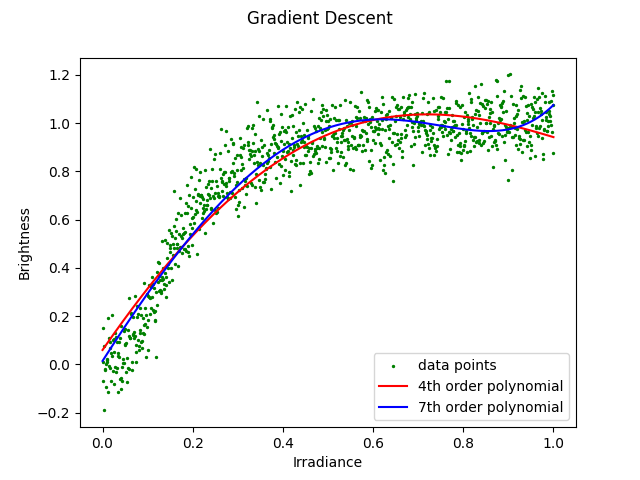

In [4]:
# Run gradient descent. These are good starting values for this task. Feel free to fine-tune parameters.
# Set up hyperparameters.
max_iter = 10000
step_size = 1e-4
tolerance = np.finfo(float).eps

# To save us some writing.
b = brightness

# Todo: Construct design matrix. Use a polynomial of order 4 and 7 here.
A_4 = np.stack([
    irradiance ** i for i in range(4+1)
], axis=-1)
A_7 = np.stack([
    irradiance ** i for i in range(6+1)
], axis=-1)

# Todo: Run gradient descent (for both settings).
x_gd_4 = graddesc(A_4, b, tolerance, max_iter, step_size)
x_gd_7 = graddesc(A_7, b, tolerance, max_iter, step_size)

# Todo: Apply fitted model parameters.
gd_result_4 = A_4 @ x_gd_4
gd_result_7 = A_7 @ x_gd_7

# Compute MSE and output some stats.
mse_graddesc_4 = mean_squared_error(gd_result_4, brightness)
mse_graddesc_7 = mean_squared_error(gd_result_7, brightness)
print("Gradient Descent Error (4): {}".format(mse_graddesc_4))
print("Gradient Descent Error (7): {}".format(mse_graddesc_7))
print("Model parameters (4): {}".format(x_gd_4))
print("Model parameters (7): {}".format(x_gd_7))

# Plot result.
fig = plt.figure()
fig.suptitle("Gradient Descent")
plt.scatter(irradiance, b, color="g", s=2)
plt.plot(irradiance, gd_result_4, color="r")
plt.plot(irradiance, gd_result_7, color="b")
plt.xlabel("Irradiance")
plt.ylabel("Brightness")
plt.legend(["data points", "4th order polynomial", "7th order polynomial"])
plt.show()

#### c) (5)
What differences can you spot between the fit of a 4th and 7th degree polynomial? What is the reason for this?
Try also other degrees and mention which degree works best in your opinion.

With the given hyperparameters, the 4th order polynomial is smoother while the 7th order polynomial has a higher curvature and minima and maxima. This is due to the higher fitting flexibility of the higher-order polynomial, it can adapt the model parameters to more variations in the data which results in a less smooth curve. The difference between the two fits decreases if we increase the maximum iterations, but the higher flexibility continues to show as higher curvature. A degree of 6 has the smallest MSE for the given hyperparameters, making it suitable for high accuracy at the selected number of iterations.

### 1.2 (30)
Implement the Conjugate Gradient Least Square (CGLS) algorithm as `conjgrad(a, b, tolerance, iterations)` and apply it to the same task.

_Hint_: You can find a detailed explanation in the lecture slides. Pay special attention to the norms. Conjugate Gradient should be much faster than the naive steepest descent approach from above. If it returns after a few steps it will mean that it works as expected.

In [5]:
def conjgrad(a: np.ndarray, b: np.ndarray, tolerance: float, iterations: int) -> np.ndarray:
    """Conjugate Gradient Least Squares optimization.
    
    Args:
        a: System matrix [n, m].
        b: Observation [n].
        tolerance: Convergence criterion as a tolerance value.
        iterations: Maximum number of iteration to run 
            (if the convergence criterion is not met).
    
    Returns:
        Estimate x [m] as a numpy array.
    """
    
    # Initialize
    x = np.ones((a.shape[1]))
    r = b - a @ x
    p = a.T @ r
    s = p
    gamma = np.sum(np.square(s))

    # Optimization loop.
    t = tqdm(range(iterations))
    for i in t:
        q = a @ p
        alpha = gamma / np.sum(np.square(q))
        x = x + alpha * p
        r = r - alpha * q
        s = a.T @ r
        gamma_0 = gamma.copy()
        gamma = np.sum(np.square(s))
        beta = gamma / gamma_0
        p = s + beta * p
        
        # Compute error (mean squared difference).
        err = np.mean(np.square(a @ x - b))
        t.set_postfix(err=err)
        if err < tolerance:
            break
    return x
        

    

  0%|          | 0/10000 [00:00<?, ?it/s]

Conjugate Gradient Error: 0.007200507509540228
Model parameters: [-0.1401322   5.063483   -7.94598815  4.84900236 -0.79063291]


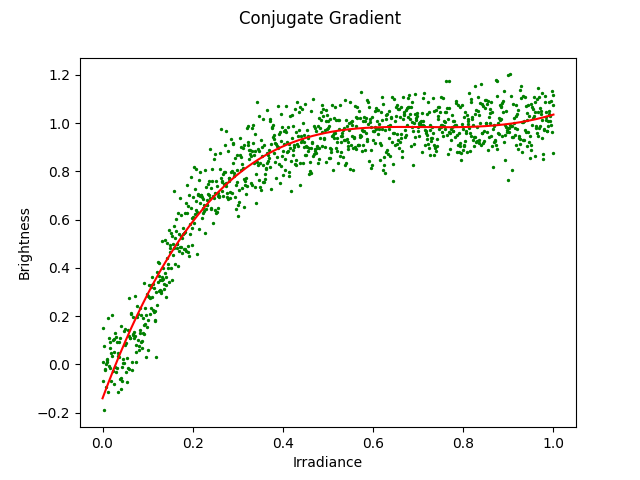

In [6]:
# Todo: Run conjugate gradient on the same data.
x_cg = conjgrad(A_4, b, tolerance, max_iter)

# Todo: Apply model parameters.
cg_result = A_4 @ x_cg

# Compute MSE and print some stats.
mse_congrad = mean_squared_error(cg_result, brightness)
print("Conjugate Gradient Error: {}".format(mse_congrad))
print("Model parameters: {}".format(x_cg))
# Plot result.
fig = plt.figure()
fig.suptitle("Conjugate Gradient")
plt.scatter(irradiance, b, color="g", s=2)
plt.plot(irradiance, cg_result, color="r")
plt.xlabel("Irradiance")
plt.ylabel("Brightness")
plt.show()

### 1.3 (10)
Explain how the search direction is chosen in the CGLS algorithm.

The search direction is chosen to be conjugate to the previous search directions with respect to A^T A to always make progress towards the solution.

The computed residual r is orthogonal to the previous residual to have efficient convergence. With it the new gradient s is computed.
We update the search direction p by weighting the previous direction with the conjugacy coefficient beta and then adding the new gradient s to it.

## 2. Non-linear methods (35 points)
Now, let's try some more advanced datafitting approaches.  Your task is to employ the __Levenberg-Marquardt__ and __Quasi-Newton (BFGS)__
algorithms on the problem of camera response curve fitting. Again, you will fit a polynomial camera response model to the measured camera response
data.  
You can use the _scipy.optimize_ library for this task. Use the provided `cam_model` function to compute the polynomial camera response with the optimized parameters.

In [7]:
# Add additional imports.
import scipy.io
import scipy.optimize
from functools import partial

def cam_model(a: np.ndarray, x: np.ndarray) -> np.ndarray:
    """Compute camera response as 7th degree polynomial.
    
    Args:
        a: Model parameters as np array [7].
        x: Data values as np array.
    
    Returns:
        Np array containing the results of the
        function evaluation on x using a.
    
    """
    return (a[0]*x + a[1]*x**2 + a[2]*x**3 
            + a[3]*x**4 + a[4]*x**5 + a[5]*x**6
            + a[6]*x**7)


### a) (20)

The Levenberg-Marquardt algorithm is implemented as part of the `scipy.optimize.least_squares` function. Find out how to use it and fit the polynomial to the measured data, __irradiance__ and __brightness__. 
Try different ways to initialize the parameters __a__ and see which give you the best results. Add a comment to explain your findings.  

Here, the optimization target or residual function can be defined as  
$$res = cam\_model(a, I) - b$$
where $a$ are your model parameters, $I$ is the measured irradiance and $b$ the measured brightness.

You will also need a function to compute the [jacobian matrix ](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) for the `cam_model` which should accept the same input as your function for the residual.

_Hint_: Look into the scipy documentation for information and usage examples.


In [8]:
# 1. Initialize 'a'. Todo: Try different initializations and write a comment about it.
a0 = np.zeros(7, dtype=np.float32)
a0 = np.ones(7, dtype=np.float32) * 1000
#a0 = np.ones(7, dtype=np.float32)
#a0 = np.random.randn(7)

# 2. Todo: Define a function to compute the residual.
# The first argument is a, which are our current model parameters.
def lm_res(a: np.ndarray, irr: np.ndarray, b: np.ndarray) -> np.ndarray:
    return cam_model(a, irr) - b

# 3. Todo: Define function to compute the jacobian for cam_model.
def jac(a: np.ndarray, irr: np.ndarray, b: np.ndarray):
    return np.stack([irr ** (i+1) for i in range(7)], -1)

# 4. Todo: Call optimizer and store results as OptimizeResult object.
result = scipy.optimize.least_squares(partial(lm_res, irr=irradiance, b=b), a0, jac=partial(jac, irr=irradiance, b=b))

# 5. Extract result and print some information.
a_lm = result["x"]
cost_lm = result["cost"]
message_lm = result["message"]

print(message_lm)
print("Terminated with cost: {}".format(cost_lm))
print("Optimized parameters from LM algorithm: {}".format(a_lm))
print(
    "Levenberg-Marquardt Error: {}".format(
        mean_squared_error(cam_model(a_lm, irradiance), brightness)
     )
)

`xtol` termination condition is satisfied.
Terminated with cost: 3.309978723526001
Optimized parameters from LM algorithm: [  -1.11942284   58.0917101  -292.73313164  679.57115949 -832.77810666
  521.34880709 -131.36417043]
Levenberg-Marquardt Error: 0.006464802110318035


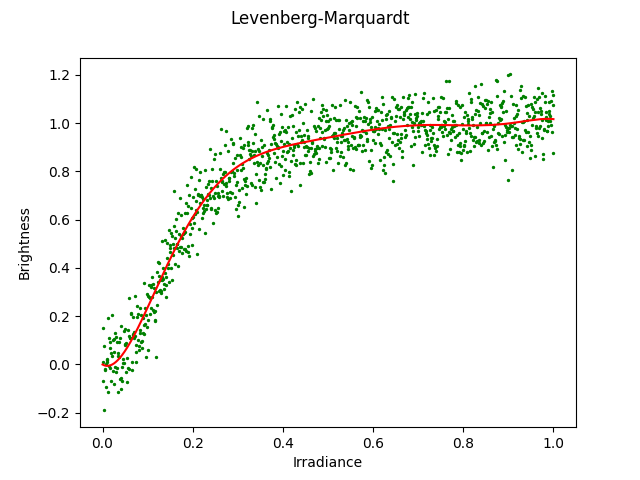

In [9]:
# Let's plot the results.
fig = plt.figure()
fig.suptitle("Levenberg-Marquardt")
plt.scatter(irradiance, brightness, color="g", s=2)
plt.plot(irradiance, cam_model(a_lm, irradiance), "r")
plt.xlabel("Irradiance")
plt.ylabel("Brightness")
plt.show()

It seems like initialization does not have a large influence on the result or the optimization cost. The cost always remains at 3.31 and the parameters only change marginally, regardless of initialization.

### b) (15)
Now it is time to test the __Quasi-Newton__ method or Broyden–Fletcher–Goldfarb–Shannon (BFGS) algorithm on our task. You can find an implementation in `scipy.optimize.minimize`. The setup is similar to before and you can reuse the `cam_model`. The residual however should be computed as the _norm_ of the residual here (the 2-norm or euclidean norm to be precise).
Again, try different initializations for __a__. Write a short comment about your observations.

_Hint_: There is no need to explicitly compute the jacobian this time, you can let scipy figure it out but you probably want to compute the jacobian matrix using the "3-point" method here instead of the default "2-point" method.

In [10]:
# 1. Initialize 'a'. Todo: Try different initializations and comment about it.
a0 = np.zeros(7)
#a0 = np.ones(7) * 1000
#a0 = np.ones(7, dtype=np.float32)
#a0 = np.random.randn(7)

# 2. Todo: Define a function to compute the residual.
# The first argument is "a", which are our current model parameters.
def qn_res(a: np.ndarray, irr: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.linalg.norm(cam_model(a, irr) - b)

# 3. Todo: Call optimizer and store results as OptimizeResult object.
result = scipy.optimize.minimize(partial(qn_res, irr=irradiance, b=b), a0, jac="3-point")

# 4. Extract result and print output.
a_bfgs = result["x"]
message_bfgs = result["message"]

print(message_bfgs)
print("Optimized parameters from BFGS algorithm: {}".format(a_bfgs))
print(
    "Quasi Newton Error: {}".format(
        mean_squared_error(cam_model(a_bfgs, irradiance), brightness)
     )
)

Desired error not necessarily achieved due to precision loss.
Optimized parameters from BFGS algorithm: [ 3.00448255  0.75049476 -7.82346822  1.26527659  5.51959876  2.69661324
 -4.42087872]
Quasi Newton Error: 0.007615203454324563


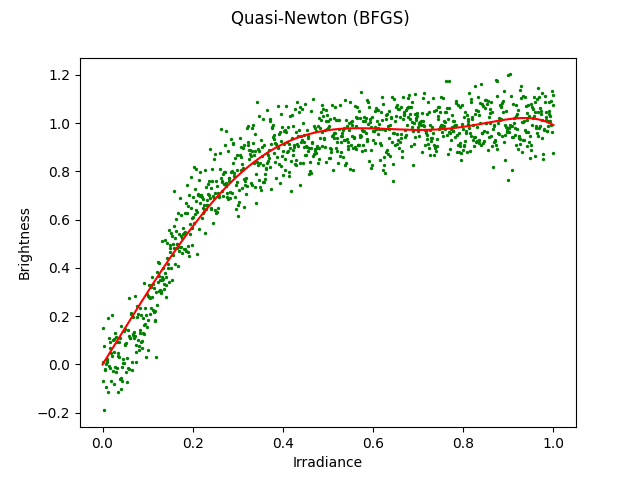

In [11]:
# Let's plot the results.
fig = plt.figure()
fig.suptitle("Quasi-Newton (BFGS)")
plt.scatter(irradiance, brightness, color="g", s=2)
plt.plot(irradiance, cam_model(a_bfgs, irradiance), "r")
plt.xlabel("Irradiance")
plt.ylabel("Brightness")
plt.show()

Here, the initialization appears to make a slight difference. The parameters change significantly depending on the initialization, even though the error remains similar. Initializing with random values performs around the same as with zeros, but ones consistently achieve the smallest error.